In [1]:
# Importing Libraries

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import centerloss

import os

cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [2]:
class Config:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

config = Config(
    num_classes = 7,
    width = 48,
    height = 48,
    num_epochs = 10,
    batch_size = 64,
    feat_dim = 11,
    lr_cent = 0.5,
    closs_weight = 0.5
)

In [3]:
# Reading Data

data = pd.read_csv('fer2013.csv')
print(data.shape)

(35887, 3)


In [4]:
#Print dataset distribution
print("Showing dataset distribution")
print(data.Usage.value_counts())

#Splitting data into training,validation and test sets
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()

#Print emotion distribution
emotion_map = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral'}

train_counts = data_train['emotion'].value_counts(sort=True).reset_index()
train_counts.columns = ['Emotion', 'Train_Samples']
train_counts['Emotion'] = train_counts['Emotion'].map(emotion_map)

val_counts = data_val['emotion'].value_counts(sort=True).reset_index()
val_counts.columns = ['Emotion', 'Val_Samples']
val_counts['Emotion'] = val_counts['Emotion'].map(emotion_map)

test_counts = data_test['emotion'].value_counts(sort=True).reset_index()
test_counts.columns = ['Emotion', 'Test_Samples']
test_counts['Emotion'] = test_counts['Emotion'].map(emotion_map)

print("\nShowing emotion distribution for train dataset")
print(train_counts)
print("\nShowing emotion distribution for val dataset")
print(val_counts)
print("\nShowing emotion distribution for test dataset")
print(test_counts)

Showing dataset distribution
Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

Showing emotion distribution for train dataset
     Emotion  Train_Samples
0  Happiness           7215
1    Neutral           4965
2    Sadness           4830
3       Fear           4097
4      Anger           3995
5   Surprise           3171
6    Disgust            436

Showing emotion distribution for val dataset
     Emotion  Val_Samples
0  Happiness          895
1    Sadness          653
2    Neutral          607
3       Fear          496
4      Anger          467
5   Surprise          415
6    Disgust           56

Showing emotion distribution for test dataset
     Emotion  Test_Samples
0  Happiness           879
1    Neutral           626
2    Sadness           594
3       Fear           528
4      Anger           491
5   Surprise           416
6    Disgust            55


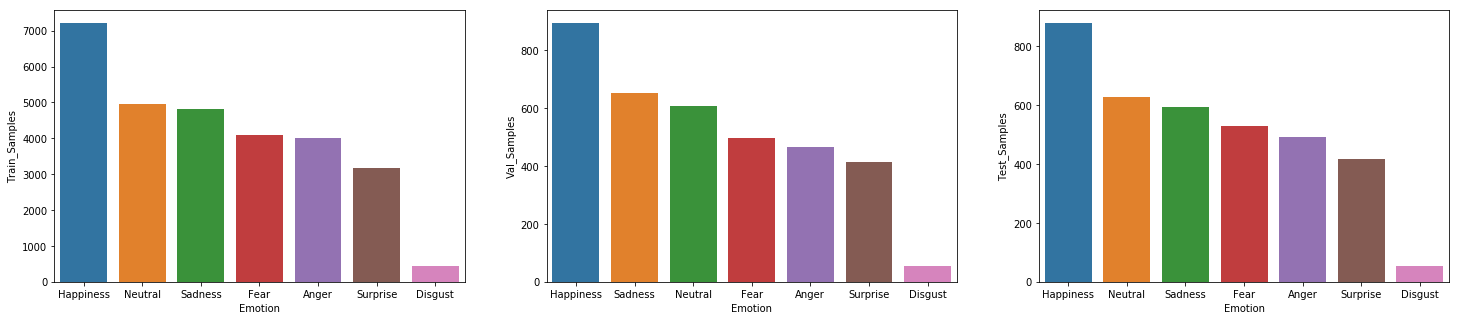

In [5]:
# Plotting bar graphs for emotion distribution

fig, axes = plt.subplots(1, 3, figsize=(25,5))

sns.barplot(train_counts.Emotion, train_counts.Train_Samples, ax=axes[0])

sns.barplot(val_counts.Emotion, val_counts.Val_Samples, ax=axes[1])

sns.barplot(test_counts.Emotion, test_counts.Test_Samples, ax=axes[2])

plt.show()

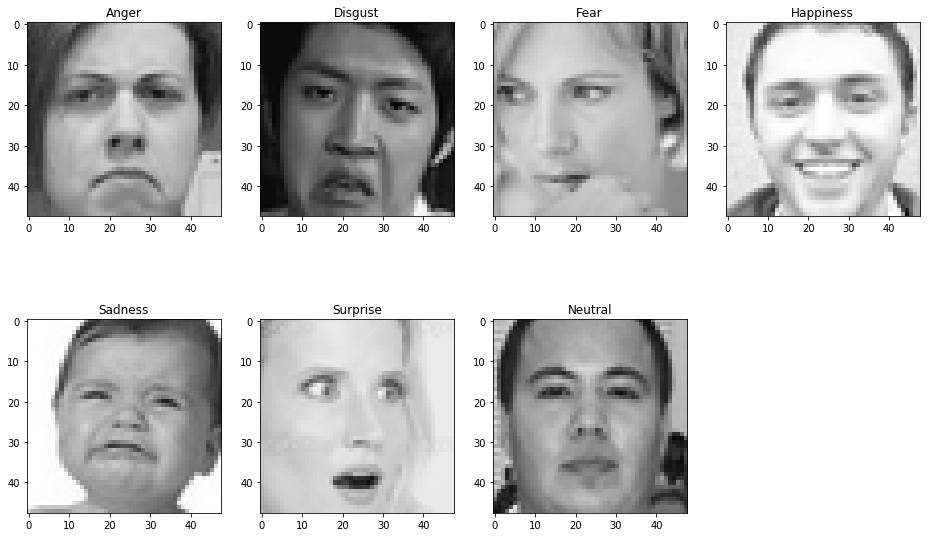

In [6]:
# Plotting some images

def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[7]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show() 

In [7]:
# Custom dataloader - Convert from string, Reshape and Normalize

class FERDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index):
        data_X = np.array(self.df['pixels'].values[index], dtype='float32').reshape(config.width, config.height)/255.0
        data_X = torchvision.transforms.ToTensor()(data_X)
        data_Y = int(self.df['emotion'].values[index])
        return data_X, data_Y

    
train_dataset = FERDataset(data_train) #training data
val_dataset   = FERDataset(data_val) #validation data
test_dataset  = FERDataset(data_test) #test data

In [9]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

28709
3589
3589


In [10]:
#Dataloaders

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True, num_workers=8)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=True, num_workers=8)

In [11]:
# Model Architecture

class ConvBlock(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
                          nn.Conv2d(in_channels=C_in, out_channels=C_out, kernel_size=kernel_size, stride=stride, padding=(1,1)),
                          nn.BatchNorm2d(C_out),
                          nn.ReLU(),
                          nn.Conv2d(in_channels=C_out, out_channels=C_out, kernel_size=kernel_size, stride=stride, padding=(1,1)),
                          nn.BatchNorm2d(C_out),
                          nn.ReLU(),
                          nn.MaxPool2d(2))
        
    def forward(self, x):
        return self.block(x)
    
class LinearBlock(nn.Module):
    def __init__(self, insize, outsize):
        super(LinearBlock, self).__init__()
        self.linblock = nn.Sequential(
                          nn.Linear(insize, outsize),
                          nn.BatchNorm1d(outsize),
                          nn.ReLU())
        
    def forward(self, x):
        return self.linblock(x)
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class BaselineModel(nn.Module):
    def __init__(self, num_blocks):
        super(BaselineModel, self).__init__()
        layers = []
        num_classes = 7
        channels = [1, 256, 128, 64] # this needs to be modified according to num_blocks
        linear_size = [64*6*6, 512, 256, 128]
        
        for i in range(num_blocks):
            layers.append(ConvBlock(C_in=channels[i], C_out=channels[i+1], kernel_size=3, stride=1))
        
        layers.append(Flatten())
        
        for i in range(num_blocks):
            layers.append(LinearBlock(linear_size[i], linear_size[i+1]))
        
        layers.append(nn.Linear(linear_size[i+1], config.num_classes))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [12]:
model = BaselineModel(num_blocks=3)
criterion = nn.CrossEntropyLoss()
criterion_closs = centerloss.CenterLoss(config.num_classes, config.feat_dim, device)
optimizer = optim.Adam(model.parameters())
optimizer_closs = torch.optim.Adam(criterion_closs.parameters(), lr=config.lr_cent)

print(model)

BaselineModel(
  (net): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5

In [13]:
import logging
logging.basicConfig(filename="training_baseline_affectnet_part_8.log" ,
                            filemode="a+")
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [14]:
def train(model,n_epochs,train_dataloader, test_loader):
    model.train()
    model.to(device)
    train_losses = []
    eval_losses = []
    eval_accs = []
    for epoch in range(n_epochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_dataloader):
            feats, labels = feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(feats)
            loss = criterion(outputs, labels.long())
            loss.backward()
            
            optimizer.step()
            
            avg_loss += loss.item()
            if batch_num % 50 == 49:
                logger.info('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
 
                avg_loss = 0.0    
        
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        train_loss, train_accuracy = test_classify_loss(model,train_dataloader)
        test_loss, test_accuracy = test_classify_loss(model,test_loader)
        eval_losses.append(test_loss)
        train_losses.append(train_loss)
        eval_accs.append(test_accuracy)
        logger.info('Epoch: {}\tTrain Loss: {}\tTrain Acc: {}\tTest-Loss: {}\tTest-acc: {:.4f}'.format(epoch+1, train_loss,train_accuracy, test_loss, test_accuracy))
    return train_losses, eval_losses, eval_accs

def test_classify_loss(model, test_loader):
    with torch.no_grad():
        model.eval()
        test_loss = []
        accuracies = 0
        total = 0
        for batch_num, (feats, labels) in enumerate(test_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            loss = criterion(outputs, labels.long())
            accuracies += float(torch.sum(torch.eq(pred_labels, labels)).item())
            total+=float(len(labels))
            test_loss.extend([loss.item()]*feats.size()[0])
            torch.cuda.empty_cache()
            del feats
            del labels
    model.train()
    return np.mean(test_loss), accuracies/total

In [ ]:
def train_closs(model,n_epochs,train_dataloader, test_loader):
    model.train()
    model.to(device)
    train_losses = []
    eval_losses = []
    eval_accs = []
    for epoch in range(n_epochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_dataloader):
            feats, labels = feats.to(device), labels.to(device)
            
            optimizer.zero_grad()
            optimizer_closs.zero_grad()
            
            outputs = model(feats)
            
            loss = criterion(outputs, labels.long())
            c_loss = criterion_closs(outputs, labels.long())
            loss = loss + config.closs_weight * c_loss
            loss.backward()
            
            optimizer.step()
            for param in criterion_closs.parameters():
                param.grad.data *= (1. / config.closs_weight)
            optimizer_closs.step()
            
            avg_loss += loss.item()
            if batch_num % 50 == 49:
                logger.info('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
 
                avg_loss = 0.0    
        
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        train_loss, train_accuracy = test_classify_closs(model,train_dataloader)
        test_loss, test_accuracy = test_classify_closs(model,test_loader)
        eval_losses.append(test_loss)
        train_losses.append(train_loss)
        eval_accs.append(test_accuracy)
        logger.info('Epoch: {}\tTrain Loss: {}\tTrain Acc: {}\tTest-Loss: {}\tTest-acc: {:.4f}'.format(epoch+1, train_loss,train_accuracy, test_loss, test_accuracy))
    return train_losses, eval_losses, eval_accs

def test_classify_closs(model, test_loader):
    with torch.no_grad():
        model.eval()
        test_loss = []
        accuracies = 0
        total = 0
        for batch_num, (feats, labels) in enumerate(test_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            loss = criterion(outputs, labels.long())
            c_loss = criterion_closs(outputs, labels.long())
            loss = loss + config.closs_weight * c_loss
            
            accuracies += float(torch.sum(torch.eq(pred_labels, labels)).item())
            total+=float(len(labels))
            test_loss.extend([loss.item()]*feats.size()[0])
            torch.cuda.empty_cache()
            del feats
            del labels
    model.train()
    return np.mean(test_loss), accuracies/total

In [15]:
train_losses, eval_losses, eval_accs = train_closs(model,config.num_epochs, train_dataloader, val_dataloader)

Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
Traceback (most recent call last):
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _

KeyboardInterrupt: 

In [ ]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.savefig("training_loss.png")

In [ ]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('accuracy')
plt.plot(eval_accs)
plt.savefig("val_acc.png")

In [ ]:
test_loss, test_accuracy = test_classify_closs(model, test_dataloader)
print("Test loss: {}, Test Accuracy: {}".format(test_loss, test_accuracy))